# Customer Segmentation for a Retail Chain - Part 2 - Clustering 

### - Team 3: 
- Sardar Rohan Singh - G01453457
- Bhargav Patel - G01448937
- Saketh - G01425738
- Monisha Jaganathan - G01412067
- Sai Saketh - G01444348

### -  Professor: Eddy Zhang
### -  Course: AIT-614-001 - Big Data Essentials

#### Importing Libraries

In [0]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.sql.functions import col, count, when


In [0]:
from pyspark.sql import SparkSession

In [0]:
retailDF = spark.read.format("csv").option("header", "true").load("dbfs:/FileStore/shared_uploads/rsardar3@gmu.edu/retail_chain.csv")

In [0]:
retailDF.printSchema()

root
 |-- InvoiceNo: string (nullable = true)
 |-- StockCode: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Quantity: string (nullable = true)
 |-- InvoiceDate: string (nullable = true)
 |-- UnitPrice: string (nullable = true)
 |-- CustomerID: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- Region: string (nullable = true)
 |-- Reviews: string (nullable = true)



In [0]:
# Copy the Dataframe in case we mess up something
df = retailDF.select(*retailDF.columns)

In [0]:
from pyspark.sql.functions import col

# Filter the DataFrame to drop rows where both 'CustomerID' and 'Description' are null
df = df.filter(~(col('CustomerID').isNull() & col('Description').isNull()))

In [0]:
# Filter out null values in Quantity and UnitPrice columns
filtered_df = df.filter(~col("Quantity").isNull() & ~col("UnitPrice").isNull())

# Convert Spark DataFrame to Pandas DataFrame
pandas_df = filtered_df.toPandas()

In [0]:
# Drop null values in the 'CustomerID' field
df = df.na.drop()

In [0]:
# Convert 'Quantity' column to numeric type, coercing errors to NaN
pandas_df['Quantity_numeric'] = pd.to_numeric(pandas_df['Quantity'], errors='coerce')

# Check for NaN values in the 'Quantity_numeric' column
non_numeric_values = pandas_df[pandas_df['Quantity_numeric'].isnull()]

# Display non-numeric values
if len(non_numeric_values) > 0:
    print("Non-numeric values found in the 'Quantity' column:")
    print(non_numeric_values)
else:
    print("No non-numeric values found in the 'Quantity' column.")

No non-numeric values found in the 'Quantity' column.


In [0]:
# Convert the Data Type of CustomerID to Integer using Lambda Function
df = df.withColumn("CustomerID", col("CustomerID").cast("int"))

In [0]:
# Draw a new column with the total price paid by the customer
df = df.withColumn("Total_Price", col("Quantity") * col("UnitPrice"))

In [0]:
from pyspark.sql import functions as F

DM_data = df.select('CustomerID', 'Quantity', 'Total_Price', 'InvoiceNo', 'InvoiceDate')

# Convert 'InvoiceDate' to datetime
DM_data = DM_data.withColumn('InvoiceDate', F.to_timestamp('InvoiceDate'))

# Data Modeling

# Analytical Objectives: Use RFM Analysis for Customer Segmentation

 •	Recency: How recently did the customer purchase?
 •	Frequency: How often does the customer make purchases?
 •	Monetary Value/Margin: How much does the customer spend?

Note: Segment the best customers/profitable customers for the retail store?

In [0]:
# To perform KMeans clustering 
from sklearn.cluster import KMeans

# To perform Hierarchical clustering
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree

Using DM_data --> Data Modelling Data for RFM AND CLUSTERING

In [0]:
DM_data.show(3)

+----------+--------+------------------+---------+-------------------+
|CustomerID|Quantity|       Total_Price|InvoiceNo|        InvoiceDate|
+----------+--------+------------------+---------+-------------------+
|     17850|       6|15.299999999999999|   536365|2010-12-01 08:26:00|
|     17850|       6|             20.34|   536365|2010-12-01 08:26:00|
|     17850|       8|              22.0|   536365|2010-12-01 08:26:00|
+----------+--------+------------------+---------+-------------------+
only showing top 3 rows



In [0]:
num_rows = DM_data.count()

# Get the number of columns in the DataFrame
num_columns = len(DM_data.columns)

# Print the number of rows and columns
print("Number of rows:", num_rows)
print("Number of columns:", num_columns)

Number of rows: 406829
Number of columns: 5


In [0]:
DM_data = DM_data.withColumn('InvoiceDate', F.to_timestamp('InvoiceDate', 'dd-MM-yyyy HH:mm'))

# Show the first few rows of the DataFrame to verify the date parsing
DM_data.show(10)

+----------+--------+------------------+---------+-------------------+
|CustomerID|Quantity|       Total_Price|InvoiceNo|        InvoiceDate|
+----------+--------+------------------+---------+-------------------+
|     17850|       6|15.299999999999999|   536365|2010-12-01 08:26:00|
|     17850|       6|             20.34|   536365|2010-12-01 08:26:00|
|     17850|       8|              22.0|   536365|2010-12-01 08:26:00|
|     17850|       6|             20.34|   536365|2010-12-01 08:26:00|
|     17850|       6|             20.34|   536365|2010-12-01 08:26:00|
|     17850|       2|              15.3|   536365|2010-12-01 08:26:00|
|     17850|       6|              25.5|   536365|2010-12-01 08:26:00|
|     17850|       6|11.100000000000001|   536366|2010-12-01 08:28:00|
|     17850|       6|11.100000000000001|   536366|2010-12-01 08:28:00|
|     13047|      32|             54.08|   536367|2010-12-01 08:34:00|
+----------+--------+------------------+---------+-------------------+
only s

In [0]:
DM_data.printSchema()

root
 |-- CustomerID: integer (nullable = true)
 |-- Quantity: string (nullable = true)
 |-- Total_Price: double (nullable = true)
 |-- InvoiceNo: string (nullable = true)
 |-- InvoiceDate: timestamp (nullable = true)



In [0]:
has_null = DM_data.select([F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in DM_data.columns]).agg(*[F.max(c).alias(c) for c in DM_data.columns])

# If any of these counts is greater than 0, then there are null values
null_exists = has_null.rdd.map(lambda row: any(x > 0 for x in row)).collect()[0]

# Print the result
print("Contains null values:", null_exists)

Contains null values: False


# RFM
# Extracting R (Recency), F (Frequency), M (Monetary) columns from the data.

# Monetary Value

In [0]:
# Monetary Function

# Finding total price spent per customer
monetary = DM_data.groupBy("CustomerID") \
                   .agg(F.round(F.sum("Total_Price"), 2).alias("Total_Spent"))
monetary = monetary.orderBy("CustomerID")
monetary.show(5)

+----------+-----------+
|CustomerID|Total_Spent|
+----------+-----------+
|     12346|        0.0|
|     12347|     4310.0|
|     12348|    1797.24|
|     12349|    1757.55|
|     12350|      334.4|
+----------+-----------+
only showing top 5 rows



# Frequency Value

In [0]:
#Frequency function

# Getting the count of orders made by each customer based on customer ID.
frequency = DM_data.groupBy("CustomerID") \
                   .agg(F.count("InvoiceNo").alias("Frequency"))
frequency = frequency.orderBy("CustomerID")
# Display the top rows to verify the data
frequency.show(5)

+----------+---------+
|CustomerID|Frequency|
+----------+---------+
|     12346|        2|
|     12347|      182|
|     12348|       31|
|     12349|       73|
|     12350|       17|
+----------+---------+
only showing top 5 rows



## Merging Total_Price and Frequency columns

In [0]:
#creating master dataset
master = monetary.join(frequency, on="CustomerID", how="inner")
master = master.select("CustomerID", "Total_Spent", "Frequency")
master = master.orderBy("CustomerID")
master.show(5)


+----------+-----------+---------+
|CustomerID|Total_Spent|Frequency|
+----------+-----------+---------+
|     12346|        0.0|        2|
|     12347|     4310.0|      182|
|     12348|    1797.24|       31|
|     12349|    1757.55|       73|
|     12350|      334.4|       17|
+----------+-----------+---------+
only showing top 5 rows



# Recency Value

In [0]:
# Finding max data
maximum = DM_data.agg(F.max("InvoiceDate"))

In [0]:
# Adding one more day to the max data, so that the max date will have 1 as the difference and not zero.
maximum = DM_data.agg(F.max("InvoiceDate"))

# Now, add one day to the maximum date and keep the same column name
maximum_plus_one = maximum.select(
    F.date_add(F.col("max(InvoiceDate)"), 1).alias("max(InvoiceDate)")
)

In [0]:
maximum_date = DM_data.agg(F.max("InvoiceDate")).collect()[0][0] + F.expr("interval 1 day")

# Broadcast the adjusted maximum date to each row and calculate the difference in days
DM_data = DM_data.withColumn("diff", F.datediff(F.lit(maximum_date), "InvoiceDate"))
DM_data.show(10)

+----------+--------+------------------+---------+-------------------+----+
|CustomerID|Quantity|       Total_Price|InvoiceNo|        InvoiceDate|diff|
+----------+--------+------------------+---------+-------------------+----+
|     17850|       6|15.299999999999999|   536365|2010-12-01 08:26:00| 374|
|     17850|       6|             20.34|   536365|2010-12-01 08:26:00| 374|
|     17850|       8|              22.0|   536365|2010-12-01 08:26:00| 374|
|     17850|       6|             20.34|   536365|2010-12-01 08:26:00| 374|
|     17850|       6|             20.34|   536365|2010-12-01 08:26:00| 374|
|     17850|       2|              15.3|   536365|2010-12-01 08:26:00| 374|
|     17850|       6|              25.5|   536365|2010-12-01 08:26:00| 374|
|     17850|       6|11.100000000000001|   536366|2010-12-01 08:28:00| 374|
|     17850|       6|11.100000000000001|   536366|2010-12-01 08:28:00| 374|
|     13047|      32|             54.08|   536367|2010-12-01 08:34:00| 374|
+----------+

In [0]:
#Dataframe merging by recency
recency = DM_data.groupBy("CustomerID") \
                 .agg(F.min("diff").alias("Min_Diff")) \
                 .orderBy("CustomerID")
recency.show(10)

+----------+--------+
|CustomerID|Min_Diff|
+----------+--------+
|     12346|     326|
|     12347|       3|
|     12348|      76|
|     12349|      19|
|     12350|     311|
|     12352|      37|
|     12353|     205|
|     12354|     233|
|     12355|     215|
|     12356|      23|
+----------+--------+
only showing top 10 rows



## RFM combined DataFrame

In [0]:
#Combining all recency, frequency and monetary parameters
# Join the master and recency dataframes on 'CustomerID'
RFM = master.join(recency, on="CustomerID")

# Rename columns directly while selecting them to match the desired column names
RFM = RFM.select(
    F.col("CustomerID"),
    F.col("Total_Spent"),
    F.col("Frequency"),
    F.col("Min_Diff").alias("Recency")
)
RFM = RFM.orderBy("CustomerID")
RFM.show(10)

+----------+-----------+---------+-------+
|CustomerID|Total_Spent|Frequency|Recency|
+----------+-----------+---------+-------+
|     12346|        0.0|        2|    326|
|     12347|     4310.0|      182|      3|
|     12348|    1797.24|       31|     76|
|     12349|    1757.55|       73|     19|
|     12350|      334.4|       17|    311|
|     12352|    1545.41|       95|     37|
|     12353|       89.0|        4|    205|
|     12354|     1079.4|       58|    233|
|     12355|      459.4|       13|    215|
|     12356|    2811.43|       59|     23|
+----------+-----------+---------+-------+
only showing top 10 rows



In [0]:
RFM.printSchema()

root
 |-- CustomerID: integer (nullable = true)
 |-- Total_Spent: double (nullable = true)
 |-- Frequency: long (nullable = false)
 |-- Recency: integer (nullable = true)



# Outlier Treatment

In [0]:
from pyspark.sql.functions import expr

# Display box plots for Total_Price, Frequency, and Recency
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
sns.boxplot(data=RFM.select("Total_Spent").toPandas())
plt.title("Total Price")

plt.subplot(1, 3, 2)
sns.boxplot(data=RFM.select("Frequency").toPandas())
plt.title("Frequency")

plt.subplot(1, 3, 3)
sns.boxplot(data=RFM.select(expr("Recency").cast("int")).toPandas())
plt.title("Recency")

plt.tight_layout()
plt.show()



In [0]:
from pyspark.sql.functions import expr

# Outlier treatment for Total_Price
q1_price = RFM.approxQuantile("Total_Spent", [0.25], 0.05)[0]  # Calculate the first quartile
q3_price = RFM.approxQuantile("Total_Spent", [0.75], 0.05)[0]  # Calculate the third quartile
iqr_price = q3_price - q1_price  # Calculate the interquartile range
# Filter the DataFrame to remove outliers
RFM = RFM.filter((RFM["Total_Spent"] >= q1_price - 1.5 * iqr_price) & (RFM["Total_Spent"] <= q3_price + 1.5 * iqr_price))

# Outlier treatment for Frequency
q1_freq = RFM.approxQuantile("Frequency", [0.25], 0.05)[0]  # Calculate the first quartile
q3_freq = RFM.approxQuantile("Frequency", [0.75], 0.05)[0]  # Calculate the third quartile
iqr_freq = q3_freq - q1_freq  # Calculate the interquartile range
# Filter the DataFrame to remove outliers
RFM = RFM.filter((RFM["Frequency"] >= q1_freq - 1.5 * iqr_freq) & (RFM["Frequency"] <= q3_freq + 1.5 * iqr_freq))

# Outlier treatment for Recency
q1_recency = RFM.approxQuantile("Recency", [0.25], 0.05)[0]  # Calculate the first quartile
q3_recency = RFM.approxQuantile("Recency", [0.75], 0.05)[0]  # Calculate the third quartile
iqr_recency = q3_recency - q1_recency  # Calculate the interquartile range
# Filter the DataFrame to remove outliers
RFM = RFM.filter((RFM["Recency"] >= q1_recency - 1.5 * iqr_recency) & (RFM["Recency"] <= q3_recency + 1.5 * iqr_recency))


In [0]:
RFM.show(10)

+----------+-----------+---------+-------+
|CustomerID|Total_Spent|Frequency|Recency|
+----------+-----------+---------+-------+
|     12346|        0.0|        2|    326|
|     12348|    1797.24|       31|     76|
|     12349|    1757.55|       73|     19|
|     12350|      334.4|       17|    311|
|     12352|    1545.41|       95|     37|
|     12353|       89.0|        4|    205|
|     12354|     1079.4|       58|    233|
|     12355|      459.4|       13|    215|
|     12356|    2811.43|       59|     23|
|     12358|    1168.06|       19|      2|
+----------+-----------+---------+-------+
only showing top 10 rows



In [0]:
# Convert PySpark DataFrame to Pandas DataFrame
RFM_pandas = RFM.select("Total_Spent").toPandas()

# Plot using seaborn
plt.figure(figsize=(4, 3), dpi=150)
sns.distplot(RFM_pandas["Total_Spent"])

plt.show()

# Scaling the RFM data

In [0]:
from pyspark.ml.feature import StandardScaler
from pyspark.sql.functions import col
from pyspark.ml.feature import VectorAssembler

# Drop the "CustomerID" column
RFM_norm1 = RFM.drop("CustomerID")

# Convert the "Recency" column to days
RFM_norm1 = RFM_norm1.withColumn("Recency", col("Recency").cast("int"))

# Assemble features into a single vector
assembler = VectorAssembler(inputCols=RFM_norm1.columns, outputCol="features")
RFM_assembled = assembler.transform(RFM_norm1)

# Initialize StandardScaler
scaler = StandardScaler(inputCol="features", outputCol="scaled_features")

# Fit and transform the data
scaler_model = scaler.fit(RFM_assembled)
RFM_scaled = scaler_model.transform(RFM_assembled)

# Show the first few rows of the scaled DataFrame
RFM_scaled.show(5, truncate=False)


+-----------+---------+-------+-------------------+-----------------------------------------------------------+
|Total_Spent|Frequency|Recency|features           |scaled_features                                            |
+-----------+---------+-------+-------------------+-----------------------------------------------------------+
|0.0        |2        |326    |[0.0,2.0,326.0]    |[0.0,0.05659158724123104,3.4810588365394337]               |
|1797.24    |31       |76     |[1797.24,31.0,76.0]|[2.8528932321237033,0.8771696022390811,0.8115351888864938] |
|1757.55    |73       |19     |[1757.55,73.0,19.0]|[2.7898903319083788,2.065592934304933,0.20288379722162345] |
|334.4      |17       |311    |[334.4,17.0,311.0] |[0.5308180859663519,0.48102849155046384,3.3208874176802574]|
|1545.41    |95       |37     |[1545.41,95.0,37.0]|[2.4531446717501795,2.688100393958474,0.39508949985263514] |
+-----------+---------+-------+-------------------+-----------------------------------------------------

# K-Means with some K

In [0]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

# Silhouette Analysis
silhouette_scores = []

for k in range(2, 15):
    kmeans = KMeans().setK(k).setSeed(1)
    model = kmeans.fit(RFM_scaled)
    predictions = model.transform(RFM_scaled)
    evaluator = ClusteringEvaluator()
    silhouette_score = evaluator.evaluate(predictions)
    silhouette_scores.append((k, silhouette_score))

silhouette_scores_df = spark.createDataFrame(silhouette_scores, ["k", "silhouette_score"])


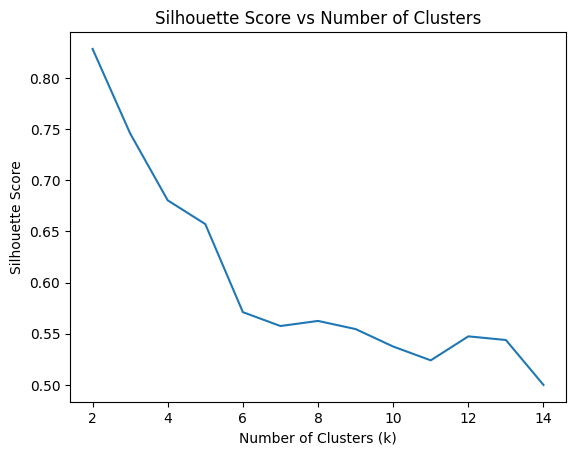

In [0]:
# Plot Silhouette Scores
silhouette_scores_pd = silhouette_scores_df.toPandas()
plt.plot(silhouette_scores_pd["k"], silhouette_scores_pd["silhouette_score"])
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score vs Number of Clusters")
plt.show()

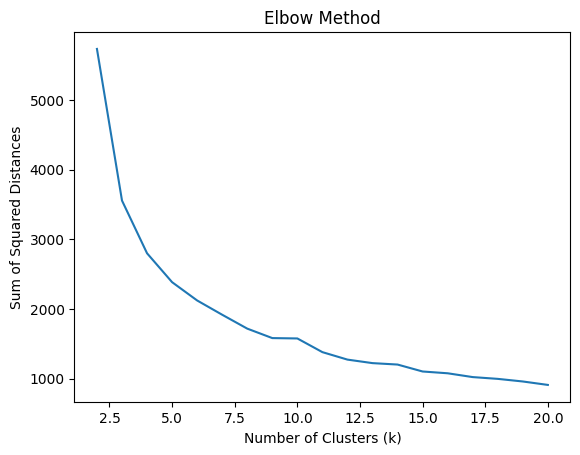

In [0]:
# Sum of Squared Distances
ssd = []

for k in range(2, 21):  # Corrected range from 2 to 20
    kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol("scaled_features")
    model = kmeans.fit(RFM_scaled)
    ssd.append(model.summary.trainingCost)

plt.plot(range(2, 21), ssd)  # Corrected range from 2 to 20
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Sum of Squared Distances")
plt.title("Elbow Method")
plt.show()

# Kmeans with K=5
kmeans = KMeans().setK(5).setSeed(1)
model = kmeans.fit(RFM_scaled)
predictions = model.transform(RFM_scaled)


In [0]:
# Analyze Clusters
RFM_km = predictions.withColumnRenamed("prediction", "ClusterID")
RFM_km = RFM_km.withColumn("Recency", RFM_km["Recency"].cast("int"))

# Aggregate cluster statistics
cluster_stats = RFM_km.groupBy("ClusterID").agg(
    F.mean("Total_Spent").alias("Total_Price_mean"),  # Corrected column name
    F.mean("Frequency").alias("Frequency_mean"),
    F.mean("Recency").alias("Recency_mean")
)

# Convert to Pandas DataFrame for plotting
cluster_stats_pd = cluster_stats.toPandas()


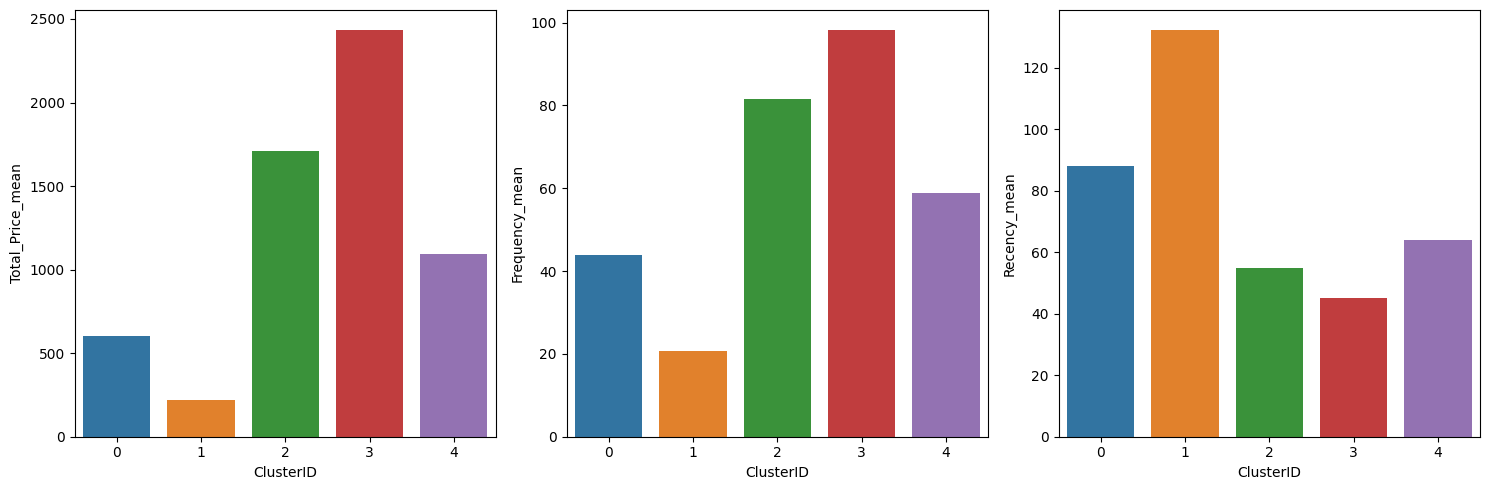

In [0]:
# Plot cluster statistics
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
sns.barplot(x="ClusterID", y="Total_Price_mean", data=cluster_stats_pd, ax=axs[0])
sns.barplot(x="ClusterID", y="Frequency_mean", data=cluster_stats_pd, ax=axs[1])
sns.barplot(x="ClusterID", y="Recency_mean", data=cluster_stats_pd, ax=axs[2])
plt.tight_layout()
plt.show()

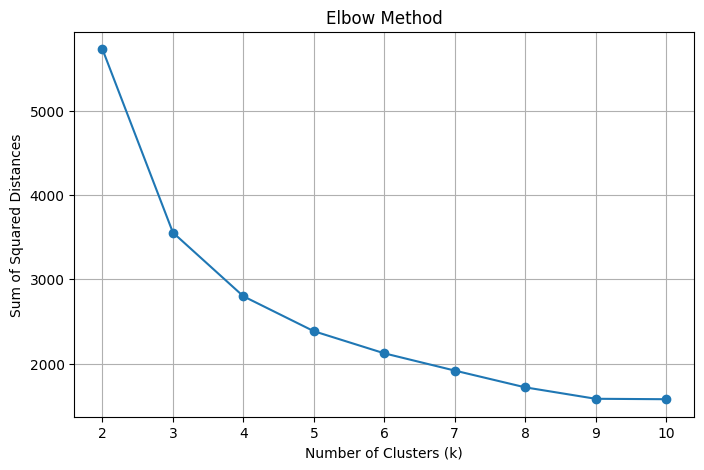

In [0]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler


# Fit KMeans clustering model with different numbers of clusters
sse_df = []
for k in range(2, 11):
    kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol("scaled_features")
    model = kmeans.fit(RFM_scaled)
    sse_df.append((k, model.summary.trainingCost))

# Plot Elbow plot to determine the optimal number of clusters
plt.figure(figsize=(8, 5))
plt.plot(*zip(*sse_df), marker='o')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Sum of Squared Distances")
plt.title("Elbow Method")
plt.grid(True)
plt.show()

In [0]:
# KMeans with K=3
kmeans = KMeans().setK(3).setSeed(1)
model = kmeans.fit(RFM_scaled)
predictions = model.transform(RFM_scaled)

# Add cluster predictions to RFM_km DataFrame
RFM_km = predictions.withColumnRenamed("prediction", "k_3")
RFM_km = RFM_km.withColumn("Recency", RFM_km["Recency"].cast("int"))

# Visualize clusters
sns.set_style("white")

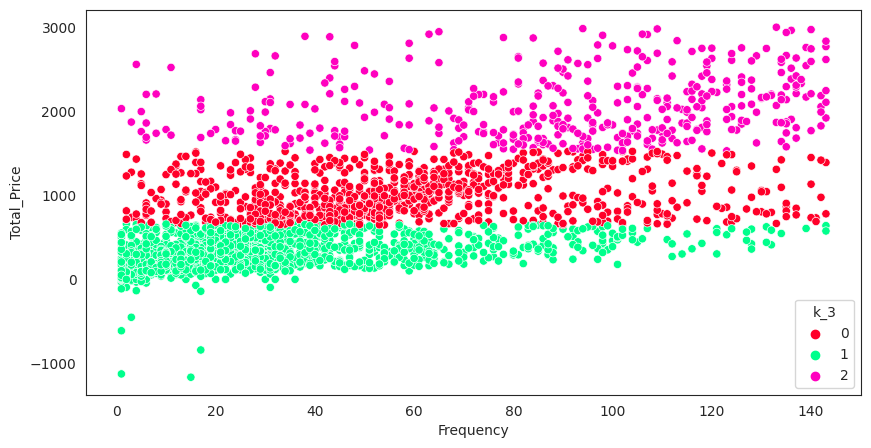

In [0]:
# Convert RFM_km DataFrame to Pandas DataFrame
RFM_km_pd = RFM_km.toPandas()

# Scatter plot of Frequency vs Total_Price
plt.figure(figsize=(10, 5))
sns.scatterplot(x='Frequency', y='Total_Spent', hue='k_3', data=RFM_km_pd, palette='gist_rainbow')
plt.xlabel('Frequency')
plt.ylabel('Total_Price')
plt.show()

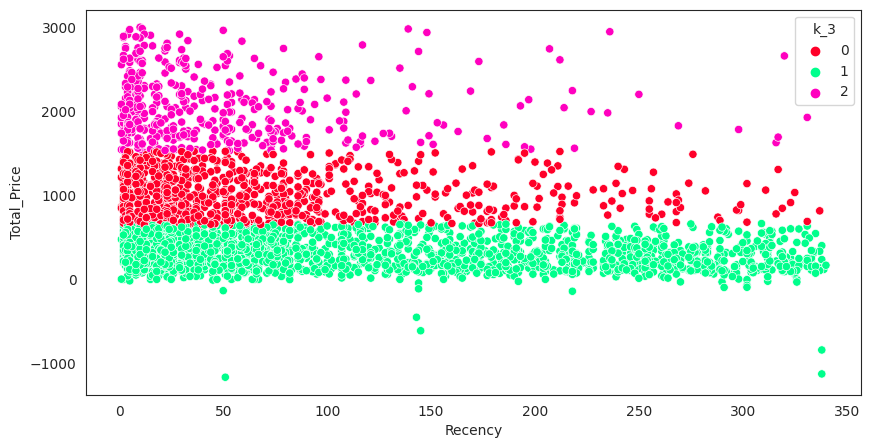

In [0]:
# Scatter plot of Recency vs Total_Price
plt.figure(figsize=(10, 5))
sns.scatterplot(x='Recency', y='Total_Spent', hue='k_3', data=RFM_km.toPandas(), palette='gist_rainbow')
plt.xlabel('Recency')
plt.ylabel('Total_Price')
plt.show()

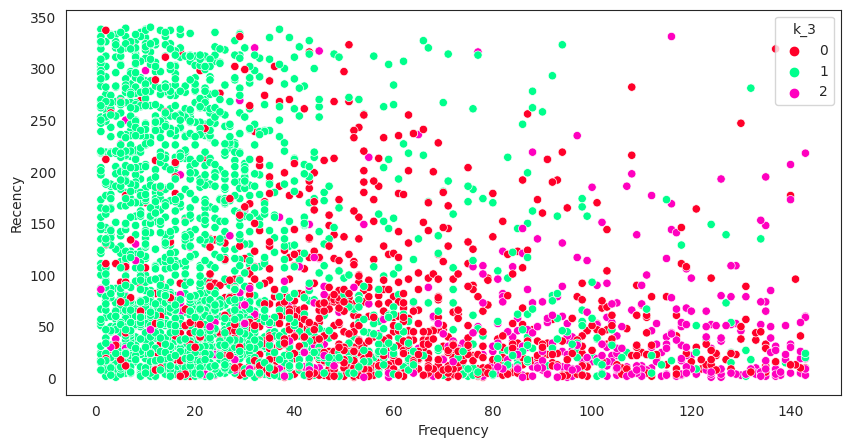

In [0]:
# Scatter plot of Frequency vs Recency
plt.figure(figsize=(10, 5))
sns.scatterplot(x='Frequency', y='Recency', hue='k_3', data=RFM_km.toPandas(), palette='gist_rainbow')
plt.xlabel('Frequency')
plt.ylabel('Recency')
plt.show()


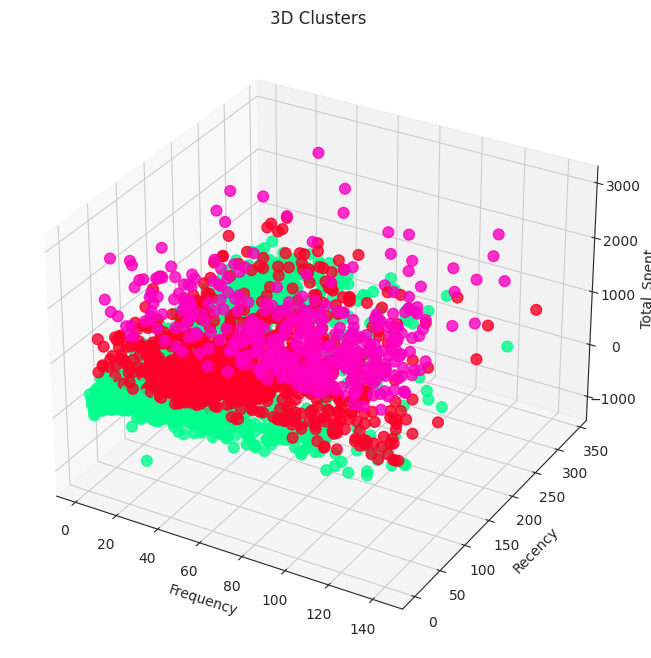

In [0]:
# 3D scatter plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
x = RFM_km.select("Frequency").rdd.flatMap(lambda x: x).collect()
y = RFM_km.select("Recency").rdd.flatMap(lambda x: x).collect()
z = RFM_km.select("Total_Spent").rdd.flatMap(lambda x: x).collect()
c = RFM_km.select("k_3").rdd.flatMap(lambda x: x).collect()
ax.scatter(x, y, z, c=c, cmap='gist_rainbow', s=60, alpha=0.8)
ax.set_xlabel('Frequency')
ax.set_ylabel('Recency')
ax.set_zlabel('Total_Spent')
ax.set_title('3D Clusters')
plt.show()

## End of Part 2